# Toy Example

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [3]:
# Data
from survae.data.datasets.toy import CheckerboardDataset
from torch.utils.data import DataLoader

# Model
import torch
import torch.nn as nn
from survae.flows import Flow
from survae.distributions import StandardNormal
from survae.transforms import AffineCouplingBijection, ActNormBijection, Reverse
from survae.nn.layers import ElementwiseParams

# Optim
from torch.optim import Adam

# Plot
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [41]:
train = CheckerboardDataset(num_points=128*1000)
test = CheckerboardDataset(num_points=128*1000)
train_loader = DataLoader(train, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=True)

## MarkDown

In [42]:
def net(n_features):
    return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
                       nn.Linear(200, 100), nn.ReLU(),
                       nn.Linear(100, n_features), ElementwiseParams(n_features))

model = Flow(base_dist=StandardNormal((2,)),
             transforms=[
               AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
               AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
               AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
               AffineCouplingBijection(net(2)), ActNormBijection(2),
             ])


### Demo Data

In [43]:
test_x = train[:1_000]

In [44]:
loss = model.log_prob(test_x)


In [45]:
z, ldj = model.forward_transform(test_x)
x_approx = model.inverse_transform(z)



In [46]:
torch.testing.assert_allclose(test_x, x_approx)

In [47]:
import corner

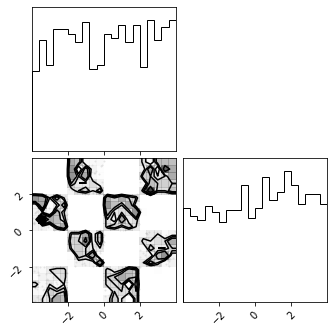

In [48]:
fig = corner.corner(test_x.detach().numpy())

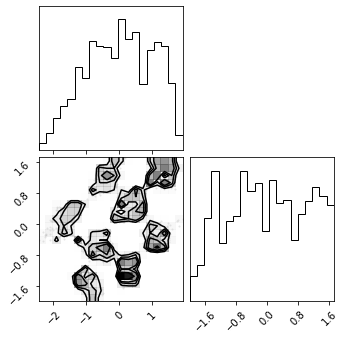

In [49]:
fig = corner.corner(z.detach().numpy())

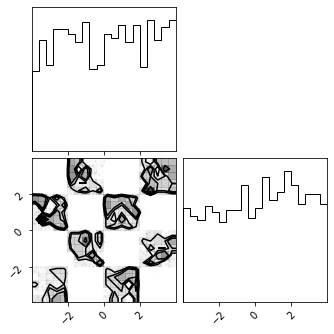

In [50]:
fig = corner.corner(x_approx.detach().numpy())

## Trainer

In [51]:
import pytorch_lightning as pl

class Learner2DPlane(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def train_dataloader(self):
        return train_loader

In [52]:
# initialize trainer
learn = Learner2DPlane(model)

In [ ]:
n_epochs = 100

# initialize trainer
trainer = pl.Trainer(min_epochs=1, max_epochs=n_epochs, gpus=1)

# train model
trainer.fit(learn)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params
-------------------------------
0 | model | Flow | 82.8 K
-------------------------------
82.8 K    Trainable params
0         Non-trainable params
82.8 K    Total params
0.331     Total estimated model params size (MB)
/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

## Latent Space

In [ ]:
# subset data
data = test.data.numpy()

z_latent, ldj = model.forward_transform(data)

In [ ]:
fig = corner.corner(z_latent.detach().numpy())

## Sampling

In [ ]:
print('Sampling...')
data = test.data.numpy()
samples = model.sample(100000).numpy()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('Data')
ax[0].hist2d(data[...,0], data[...,1], bins=256, range=[[-4, 4], [-4, 4]])
ax[0].set_xlim([-4, 4]); ax[0].set_ylim([-4, 4]); ax[0].axis('off')
ax[1].set_title('Samples')
ax[1].hist2d(samples[...,0], samples[...,1], bins=256, range=[[-4, 4], [-4, 4]])
ax[1].set_xlim([-4, 4]); ax[1].set_ylim([-4, 4]); ax[1].axis('off')
plt.tight_layout()
plt.show()

